# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [26]:
#Pandas, Numpy
import numpy as np
import pandas as pd

#Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn models, Pipeline & Metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

In [32]:
df = pd.read_csv('vehicles.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [33]:
df.isnull().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

In [34]:
df.shape

(426880, 18)

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

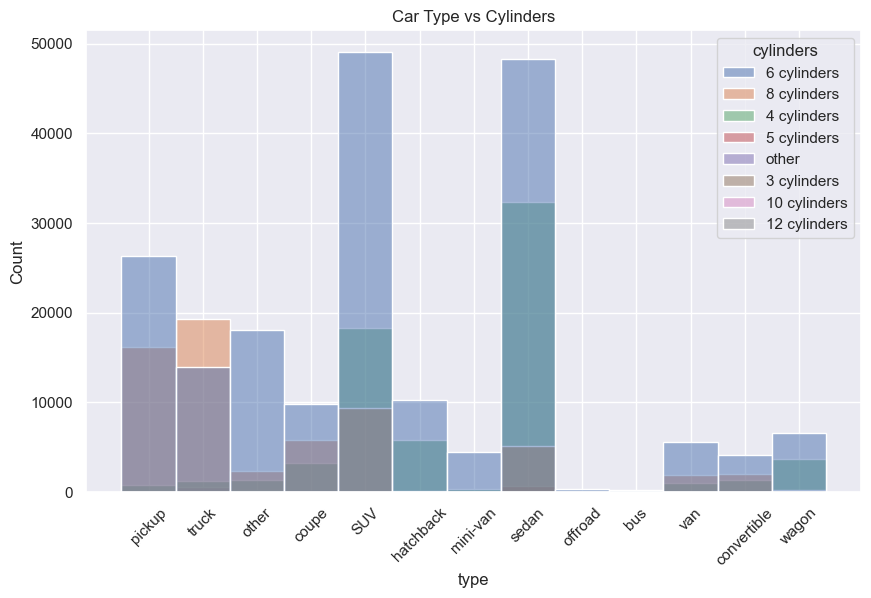

In [42]:
#Data Cleaning & Preparation 

#Fillna of Year with mode value
df['year'] = df['year'].fillna(df['year'].mode()[0])

##Fillna of condition with mode value
df['condition'] = df['condition'].fillna(df['condition'].mode()[0])

##Fillna of Cylinders with mode value
df['cylinders'] = df['cylinders'].fillna(df['cylinders'].mode()[0])

##Fillna of fuel with mode value
df['fuel'] = df['fuel'].fillna(df['fuel'].mode()[0])

# Visualize Fuel Type vs Car Cylinders
plt.figure(figsize=(10, 6))
sns.set_theme(style="darkgrid")
sns.histplot(data=df, x='type', hue='cylinders' )
plt.xticks(rotation=45)
plt.title('Car Type vs Cylinders')
plt.savefig("images/carTypeCylinders.png")
plt.show()

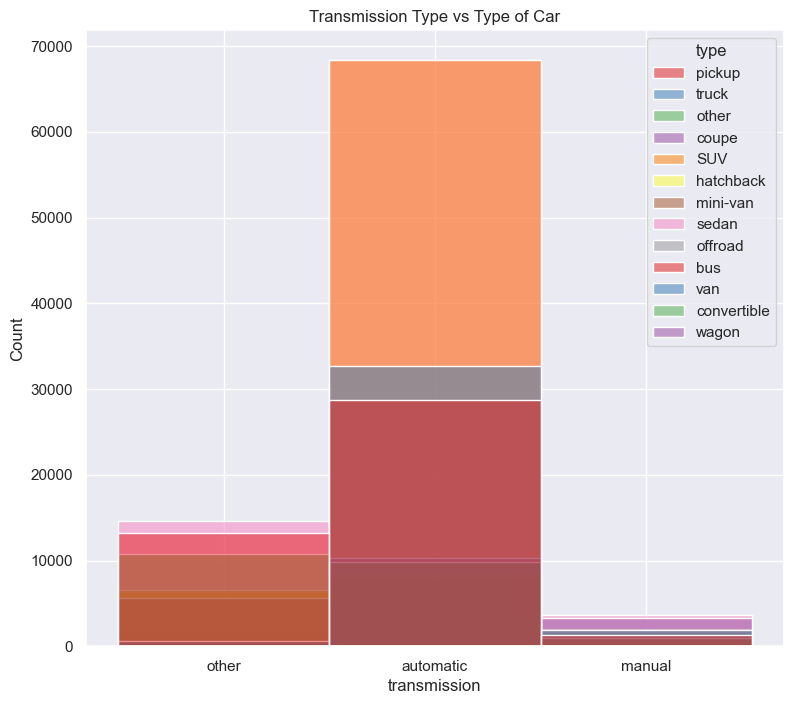

In [53]:
#As the price value varies quite a bit, it is good to change it to to logarthimic
df['price'] = df['price'].apply(lambda amt: max(1, amt)).astype(float).apply(np.log)

# Visualize Fuel Type vs Car Cylinders
plt.figure(figsize=(9, 8))
sns.set_theme(style="darkgrid")
sns.histplot(data=df, x='transmission', hue='type', bins=10, palette="Set1")
plt.title('Transmission Type vs Type of Car')
plt.savefig("images/TransmissionTypeCarType.png")
plt.show()

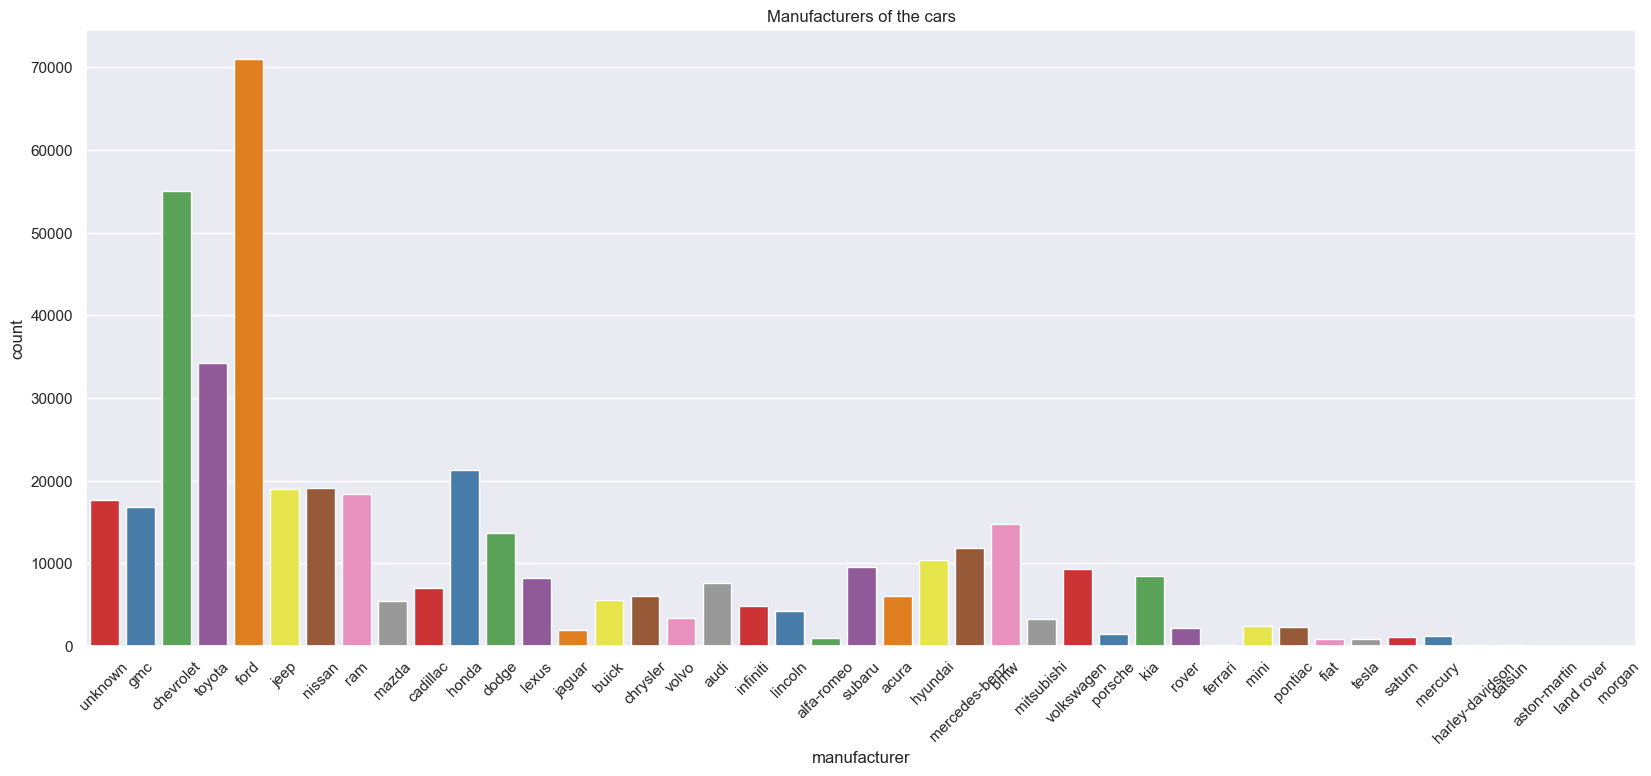

In [54]:
#More Data cleaning and preparation

##Fillna of Title with mode value
df['title_status'] = df['title_status'].fillna(df['title_status'].mode()[0])

##Fillna of Transmission with mode value
df['transmission'] = df['transmission'].fillna(df['transmission'].mode()[0])

##Fillna of drive with mode value
df['drive'] = df['drive'].fillna(df['drive'].mode()[0])

##Fillna of size with mode value
df['size'] = df['size'].fillna(df['size'].mode()[0])

##Fillna of type with mode value
df['type'] = df['type'].fillna(df['type'].mode()[0])

##Fillna of paint_color with mode value
df['paint_color'] = df['paint_color'].fillna(df['paint_color'].mode()[0])

df['odometer'] = df['odometer'].fillna(df['odometer'].median())

##Fillna of type with median value
df['type'] = df['type'].fillna(df['type'].mode()[0])

##Fillna of manufacturer with 'unknown'
df['manufacturer'] = df['manufacturer'].fillna('unknown')

#Visualize Cars by Manufacturers

sns.set_theme(style="darkgrid")
plt.figure(figsize=(20, 8))
x = sns.countplot(x="manufacturer", data=df, palette="Set1")
plt.title('Manufacturers of the cars')
plt.xticks(rotation = 45)
plt.savefig("images/manufacturers.png")
plt.show()

In [59]:
#Since Id, VIN is not relevant for price prediction, we can drop the column
# Due to high cardinality and its relevance in large dataset - region and model can be dropped as well
df.drop(columns={'id', 'VIN', 'region', 'model', 'state'}, inplace=True)

In [61]:
X = df.drop(columns=['price'])
y = df['price']
X.head(5), y.head(5)

(     year manufacturer condition    cylinders fuel  odometer title_status  \
 0  2017.0      unknown      good  6 cylinders  gas   85548.0        clean   
 1  2017.0      unknown      good  6 cylinders  gas   85548.0        clean   
 2  2017.0      unknown      good  6 cylinders  gas   85548.0        clean   
 3  2017.0      unknown      good  6 cylinders  gas   85548.0        clean   
 4  2017.0      unknown      good  6 cylinders  gas   85548.0        clean   
 
   transmission drive       size   type paint_color  
 0    automatic   4wd  full-size  sedan       white  
 1    automatic   4wd  full-size  sedan       white  
 2    automatic   4wd  full-size  sedan       white  
 3    automatic   4wd  full-size  sedan       white  
 4    automatic   4wd  full-size  sedan       white  ,
 0    2.163267
 1    2.239037
 2    2.297801
 3    1.989684
 4    2.139712
 Name: price, dtype: float64)

In [62]:
transformer_columns = ['condition','manufacturer', 'cylinders','fuel', 'title_status' ,'transmission' ,'drive','size', 'type','paint_color']
one_transformer = make_column_transformer((OneHotEncoder(drop='if_binary'), transformer_columns), remainder='passthrough')


In [63]:
# Split the data into train and test set.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_scaled = one_transformer.fit_transform(X_train, y_train)
X_test_scaled = one_transformer.fit(X_test, y_test)

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [64]:
%%time

#Lasso Regression explored for Used Car Pricing

lasso_pipe = Pipeline([('transformer', one_transformer),
                 ('lso', Lasso(random_state=42))])

lasso_pipe.fit(X_train, y_train)

y_pred_lasso_train = lasso_pipe.predict(X_train)
y_pred_lasso_test = lasso_pipe.predict(X_test)

print(f'Training MSE - {mean_squared_error(y_train, y_pred_lasso_train)}')
print(f'Training MSE - {mean_squared_error(y_test, y_pred_lasso_test)}')

Training MSE - 0.3923111754344084
Training MSE - 0.3873075038251156
CPU times: user 2.44 s, sys: 572 ms, total: 3.01 s
Wall time: 1.69 s


In [65]:
#Lasso Regression explored for Used Car Pricing

pipe = Pipeline([('transformer', one_transformer),
                 ('lso', Lasso(random_state=42))])

lso_param_grid = {   
    'lso__alpha' : [0.02, 0.024, 0.025, 0.026, 0.03],
    'lso__max_iter' : [100, 1000]
}

lso_grid = GridSearchCV(pipe, param_grid=lso_param_grid, scoring='neg_mean_squared_error')
lso_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['condition',
                                                                          'manufacturer',
                                                                          'cylinders',
                                                                          'fuel',
                                                                          'title_status',
                                                                          'transmission',
                                                                          'drive',
                                                                          'size',
                                                                          'type',
                                                                          'paint_color'])])),
                                       ('lso', Lasso(random_state=42))]),
             param_grid={'lso__alpha': [0.02, 0.024, 0.025, 0.026, 0.03],
                         'lso__max_iter': [100, 1000]},
             scoring='neg_mean_squared_error')

In [66]:
print(lso_grid.best_params_)
print(lso_grid.best_estimator_)
print(lso_grid.best_score_)

{'lso__alpha': 0.02, 'lso__max_iter': 100}
Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['condition', 'manufacturer',
                                                   'cylinders', 'fuel',
                                                   'title_status',
                                                   'transmission', 'drive',
                                                   'size', 'type',
                                                   'paint_color'])])),
                ('lso', Lasso(alpha=0.02, max_iter=100, random_state=42))])
-0.3880374303430636


In [67]:
y_pred_lasso_grid_train = lso_grid.best_estimator_.predict(X_train)
y_pred_lasso_grid_test = lso_grid.best_estimator_.predict(X_test)

print(f'Training MSE - {mean_squared_error(y_train, y_pred_lasso_grid_train)}')
print(f'Training MSE - {mean_squared_error(y_test, y_pred_lasso_grid_test)}')

Training MSE - 0.3880324725802647
Training MSE - 0.38311766979784767


In [69]:
# Ridge Regression for User Car Price Prediction

pipe2 = Pipeline([('transformer', one_transformer),
                 ('rdg', Ridge(random_state=42))])

rdg_param_grid = {   
    'rdg__alpha' : [0.02, 0.024, 0.025, 0.026]
}

rdg_grid = GridSearchCV(pipe2, param_grid=rdg_param_grid, scoring='neg_mean_squared_error', error_score='raise')
rdg_grid.fit(X_train, y_train)


GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['condition',
                                                                          'manufacturer',
                                                                          'cylinders',
                                                                          'fuel',
                                                                          'title_status',
                                                                          'transmission',
                                                                          'drive',
                                                                          'size',
                                                                          'type',
                                                                          'paint_color'])])),
                                       ('rdg', Ridge(random_state=42))]),
             param_grid={'rdg__alpha': [0.02, 0.024, 0.025, 0.026]},
             scoring='neg_mean_squared_error')

In [70]:
print(rdg_grid.best_params_)
print(rdg_grid.best_estimator_)
print(rdg_grid.best_score_)

{'rdg__alpha': 0.02}
Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['condition', 'manufacturer',
                                                   'cylinders', 'fuel',
                                                   'title_status',
                                                   'transmission', 'drive',
                                                   'size', 'type',
                                                   'paint_color'])])),
                ('rdg', Ridge(alpha=0.02, random_state=42))])
-0.3923223470889171


In [71]:
y_pred_rdg_grid_train = rdg_grid.best_estimator_.predict(X_train)
y_pred_rdg_grid_test = rdg_grid.best_estimator_.predict(X_test)

print(f'Training MSE - {mean_squared_error(y_train, y_pred_rdg_grid_train)}')
print(f'Training MSE - {mean_squared_error(y_test, y_pred_rdg_grid_test)}')

Training MSE - 0.39231117541062405
Training MSE - 0.38730749966533284


In [73]:
#Decision Tree Regression for User Car Price Prediction

pipe3 = Pipeline([('transformer', one_transformer),
                 ('dtr', DecisionTreeRegressor(random_state=42))])

dtr_param_grid = {
    'dtr__ccp_alpha': [0.000, 0.005, 0.010]
}
    
dtr_grid = GridSearchCV(pipe3, param_grid=dtr_param_grid, scoring='neg_mean_squared_error', error_score='raise')
dtr_grid.fit(X_train, y_train)




GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['condition',
                                                                          'manufacturer',
                                                                          'cylinders',
                                                                          'fuel',
                                                                          'title_status',
                                                                          'transmission',
                                                                          'drive',
                                                                          'size',
                                                                          'type',
                                                                          'paint_color'])])),
                                       ('dtr',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid={'dtr__ccp_alpha': [0.0, 0.005, 0.01]},
             scoring='neg_mean_squared_error')

In [74]:
print(dtr_grid.best_params_)
print(dtr_grid.best_estimator_)
print(dtr_grid.best_score_)

{'dtr__ccp_alpha': 0.0}
Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['condition', 'manufacturer',
                                                   'cylinders', 'fuel',
                                                   'title_status',
                                                   'transmission', 'drive',
                                                   'size', 'type',
                                                   'paint_color'])])),
                ('dtr', DecisionTreeRegressor(random_state=42))])
-0.314133551756487


In [75]:
y_pred_dtr_grid_train = dtr_grid.best_estimator_.predict(X_train)
y_pred_dtr_grid_test = dtr_grid.best_estimator_.predict(X_test)

print(f'Training MSE - {mean_squared_error(y_train, y_pred_dtr_grid_train)}')
print(f'Training MSE - {mean_squared_error(y_test, y_pred_dtr_grid_test)}')

Training MSE - 0.014293060372899388
Training MSE - 0.29011258402711604


In [81]:
%%time
gbr_pipe = Pipeline([('transformer', one_transformer),
                 ('gbr', GradientBoostingRegressor(learning_rate=0.001, n_estimators=100, random_state=42))])

gbr_param_grid = {
    'gbr__learning_rate': [0.001, 0.01, 0.015, 0.020, 0.025]
}

    
gbr_grid = GridSearchCV(gbr_pipe, param_grid=gbr_param_grid, scoring='neg_mean_squared_error', error_score='raise')

gbr_grid.fit(X_train, y_train)

CPU times: user 10min 4s, sys: 9.41 s, total: 10min 13s
Wall time: 10min 14s


GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['condition',
                                                                          'manufacturer',
                                                                          'cylinders',
                                                                          'fuel',
                                                                          'title_status',
                                                                          'transmission',
                                                                          'drive',
                                                                          'size',
                                                                          'type',
                                                                          'paint_color'])])),
                                       ('gbr',
                                        GradientBoostingRegressor(learning_rate=0.001,
                                                                  random_state=42))]),
             param_grid={'gbr__learning_rate': [0.001, 0.01, 0.015, 0.02,
                                                0.025]},
             scoring='neg_mean_squared_error')

In [82]:
print(gbr_grid.best_params_)
print(gbr_grid.best_estimator_)
print(gbr_grid.best_score_)

{'gbr__learning_rate': 0.025}
Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['condition', 'manufacturer',
                                                   'cylinders', 'fuel',
                                                   'title_status',
                                                   'transmission', 'drive',
                                                   'size', 'type',
                                                   'paint_color'])])),
                ('gbr',
                 GradientBoostingRegressor(learning_rate=0.025,
                                           random_state=42))])
-0.36718824403183004


In [100]:
y_pred_gbr_grid_train = gbr_grid.best_estimator_.predict(X_train)
y_pred_gbr_grid_test = gbr_grid.best_estimator_.predict(X_test)

print(f'Training MSE - {mean_squared_error(y_train, y_pred_gbr_grid_train)}')
print(f'Training MSE - {mean_squared_error(y_test, y_pred_gbr_grid_test)}')

Training MSE - 0.3669843327481504
Training MSE - 0.36300072553457957


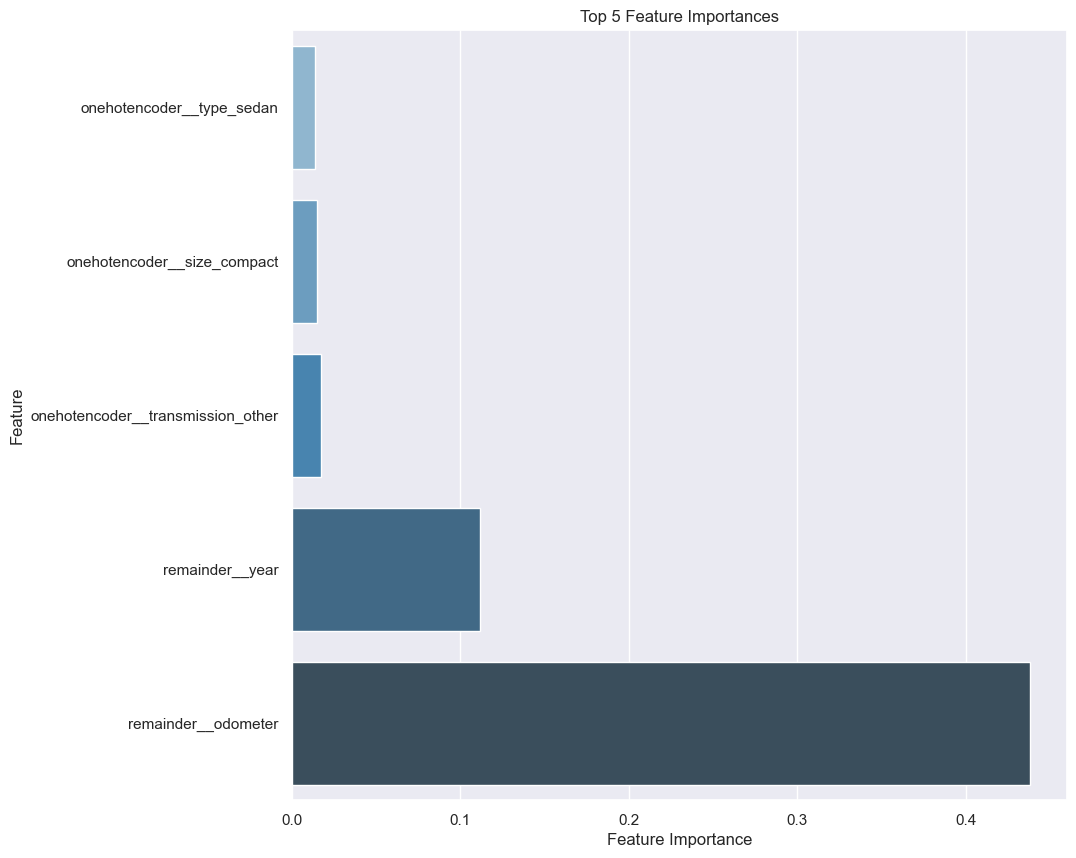

In [102]:
# Plot feature importances from Decision Tree Regressor

feature_importances = pd.Series(dtr_grid.best_estimator_.named_steps.dtr.feature_importances_, index=dtr_grid.best_estimator_.named_steps.transformer.get_feature_names_out())
top_n = 5
sorted_feature_importances = feature_importances.sort_values()[-top_n:]
plt.figure(figsize=(10,10))
sns.barplot(x=sorted_feature_importances.values, y=sorted_feature_importances.index, orient="h", palette="Blues_d")
plt.title("Top {} Feature Importances".format(top_n))
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [107]:
# Decision Tree Regressor happen to be the best performing model with low Training MSE and Test MSE 

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

In [106]:
# Odometer, Year, Transmission(Other), Car Size(Compact) and Paint Color(White) seems to be top features that seem to affect the price of the car.